In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [2]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (12.0, 8.0)

## Disclaimer

Given that this data is specific to Ames, Iowa, any insights provided by this model are unlikely to generalize to the rest of the US. Ames is a college town, home to Iowa State University (1), with a population less than 60,000 in 2010 (2), the last year this data was collected. The insights from this model likely apply best to other college towns in the central US and the midwest.

1) https://www.cityofames.org/  
2) https://worldpopulationreview.com/us-cities/ames-ia-population

# Linear Regression Model

**Preprocess the data**

In [3]:
# Drop columns specified by notebook 05
to_drop = ['Total Bsmt SF',
         'Alley Pave',
         'MS SubClass_90',
         'Utilities_NoSewr',
         'MS Zoning_I (all)',
         'Bldg Type_Duplex',
         'BsmtFin SF 2',
         'Has Alley',
         'BsmtFin SF 1',
         'Bsmt Unf SF']

In [4]:
# Load data
train = pd.read_csv('../datasets/clean/train_engineered.csv')
train.drop(columns=to_drop, inplace=True)

# Set features and target
X = train._get_numeric_data().drop(columns='SalePrice')
y = train['SalePrice']

# Scale the data
sc = StandardScaler()
Z = sc.fit_transform(X)

# Save column names
features = list(X.columns)

## Train model

In [5]:
# Set features and target
X = train._get_numeric_data().drop(columns='SalePrice')
y = train['SalePrice']

# Scale the data
sc = StandardScaler()
Z = sc.fit_transform(X)

# Save column names
features = list(X.columns)

In [6]:
# Create model
model = LinearRegression()

# Fit the model on training data
model.fit(Z, y)

LinearRegression()

### Investigate coefficients

In [7]:
def build_coef_df(features, model):
    coef = pd.DataFrame([features, model.coef_]).T.sort_values(1, ascending=False)
    coef.rename(columns={0:'feature', 1:'coefficient'}, inplace=True)
    coef.set_index('feature', drop=True, inplace=True)

    return coef

In [8]:
def get_binary_features(coef):
    '''Identify binary features'''
    binary_cols = []
    for col in coef.index:
        if len(train[col].unique()) <= 2:
            binary_cols.append(col)

    return binary_cols

In [9]:
def get_numeric_features(coef):
    '''Identify non-binary features'''
    numeric_cols = []
    for col in coef.index:
        if len(train[col].unique()) > 2:
            numeric_cols.append(col)

    return numeric_cols

In [10]:
coef = build_coef_df(features, model)

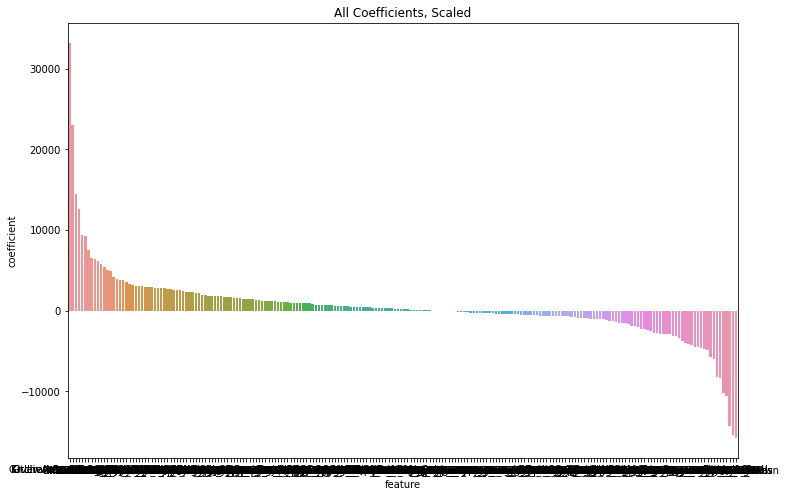

In [11]:
sns.barplot(x=coef.index, y='coefficient', data=coef)
plt.title('All Coefficients, Scaled');

**Interpretation:** Many features show significant contributions, but a few stand out at the extremes. let's take a closer look at the most impactful features.

## Features with large contribution to target
**Numeric Features**

In [12]:
numeric_cols = get_numeric_features(coef)
num_df = coef.loc[numeric_cols, :]

In [13]:
# Large positive contribution
num_df.head(15)

,coefficient
feature,
Gr Liv Area Overall Qual,33209.1
Gr Liv Area Kitchen Qual,22980.7
Kitchen Qual Overall Qual,14502.8
Overall Qual Total Bsmt SF,12608.6
Overall Cond,5814.84
Garage Area,5448.33
Bsmt Full Bath,4119.47
Screen Porch,3510.89
Mas Vnr Area,3023.63


**Look at significant positively contributing features**

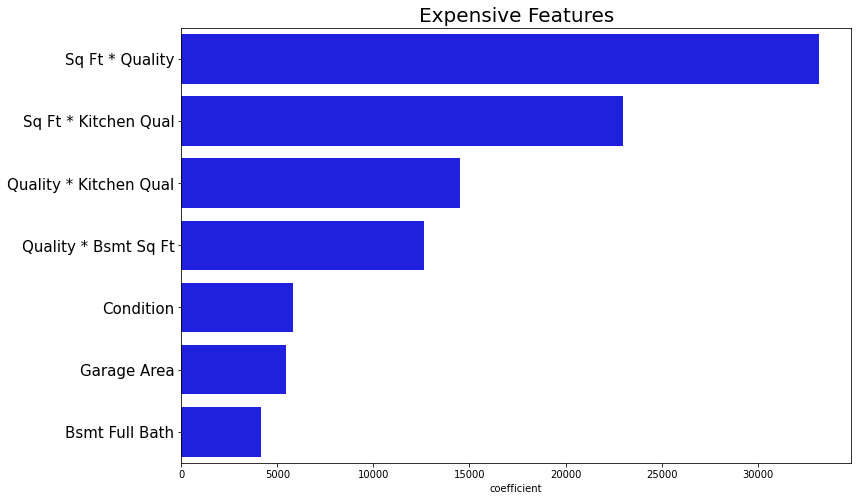

In [14]:
df = num_df.head(7)
feature_names = ['Sq Ft * Quality', 'Sq Ft * Kitchen Qual', 'Quality * Kitchen Qual', 'Quality * Bsmt Sq Ft', 'Condition', 'Garage Area', 'Bsmt Full Bath']
df.index = feature_names

f,ax = plt.subplots()

sns.barplot(y = df.index, x = df['coefficient'], color='blue', orient='h', ax=ax)
plt.title('Expensive Features', size=20)
ax.yaxis.set_tick_params(labelsize=15);

f.savefig("../plots/numeric_scaled.png", bbox_inches='tight', dpi=600)

**Binary Features**

In [15]:
binary_cols = get_binary_features(coef)
binary_df = coef.loc[binary_cols, :]

In [16]:
df_2 = binary_df.head(50)
df_2 = df_2.loc[['Garage Type_Detchd', 'Paved Drive_Y'], :]

**Look at significant positively contributing features**

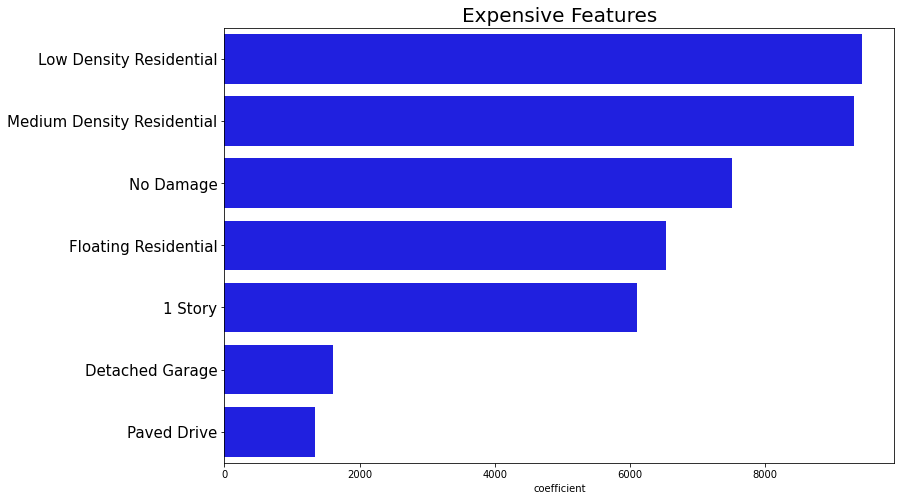

In [17]:
# Largest effect on price increase of binary features 
df = binary_df.head(6)
df = df.drop(index='Exterior 2nd_VinylSd')

# Lesser effects for reference
df_2 = binary_df.head(50)
df_2 = df_2.loc[['Garage Type_Detchd', 'Paved Drive_Y'], :]

# Package for plotting
df = pd.concat([df,df_2], axis=0)
feature_names = ['Low Density Residential', 'Medium Density Residential', 'No Damage', 'Floating Residential', '1 Story', 'Detached Garage', 'Paved Drive']
df.index = feature_names

f,ax = plt.subplots()

sns.barplot(y = df.index, x = df['coefficient'], color='blue', orient='h', ax=ax)
plt.title('Expensive Features', size=20)
ax.yaxis.set_tick_params(labelsize=15);

f.savefig("../plots/binary_scaled.png", bbox_inches='tight', dpi=600)

## Set Features
* Examine unchangeable features
* These determine which homes to purchase

In [18]:
set_features = ['Gr Liv Area Overall Qual', 'Overall Qual Total Bsmt SF', 'MS Zoning_RL', 'MS Zoning_RM', 'MS Zoning_FV', 'House Style_1Story']
feature_names = ['Sq Ft * Quality', 'Quality * Bsmt Sq Ft', 'Low Density Residential', 'Medium Density Residential', 'Floating Village Residential', '1 Story']

In [19]:
set_df = coef.loc[set_features, :]
set_df.index = feature_names
set_df['color'] = ['Numeric', 'Numeric', 'Yes or No', 'Yes or No', 'Yes or No', 'Yes or No']

In [20]:
set_df

,coefficient,color
Sq Ft * Quality,33209.1,Numeric
Quality * Bsmt Sq Ft,12608.6,Numeric
Low Density Residential,9436.26,Yes or No
Medium Density Residential,9311.13,Yes or No
Floating Village Residential,6536.13,Yes or No
1 Story,6103.09,Yes or No


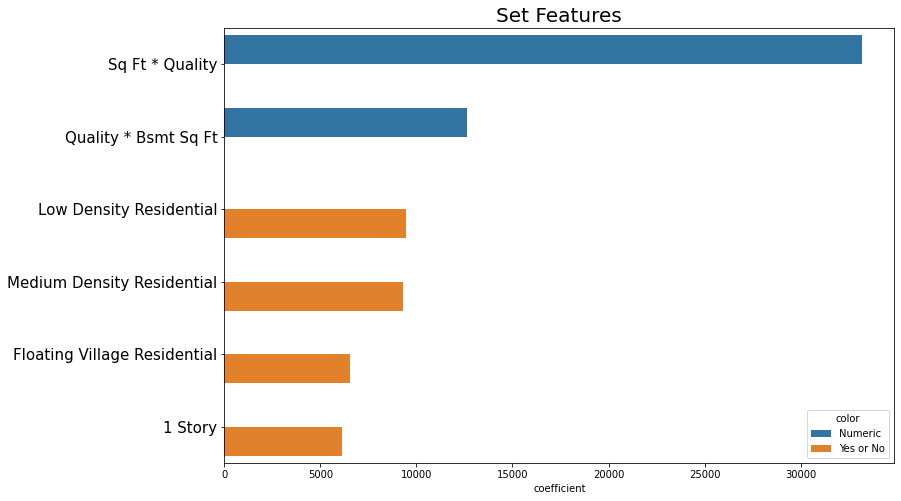

In [21]:
f,ax = plt.subplots()

sns.barplot(y = set_df.index, x = set_df['coefficient'], hue=set_df['color'], orient='h', ax=ax)
plt.title('Set Features', size=20)
ax.yaxis.set_tick_params(labelsize=15);

f.savefig("../plots/set-features.png", bbox_inches='tight', dpi=600)

**Interpretation:** Sq Ft and quality interaction term dominates. Binary features with the strongest positive contributions to sale price relate to zoning and the number of stories.

## Renovation Features
* Examine features ideal for renovation.
* These determine which projects to invest your renovation budget in.

In [22]:
renovation_features = ['Overall Cond', 'Bsmt Full Bath', 'Half Bath', 'Fireplaces', 'Paved Drive_Y']
feature_names = ['Condition', 'Bsmt Full Bath', 'Half Bath', 'Fireplaces', 'Paved Driveway']

In [23]:
renovation_df = coef.loc[renovation_features, :]
renovation_df.index = feature_names

In [24]:
renovation_df

,coefficient
Condition,5814.84
Bsmt Full Bath,4119.47
Half Bath,2642.08
Fireplaces,2577.96
Paved Driveway,1333.07


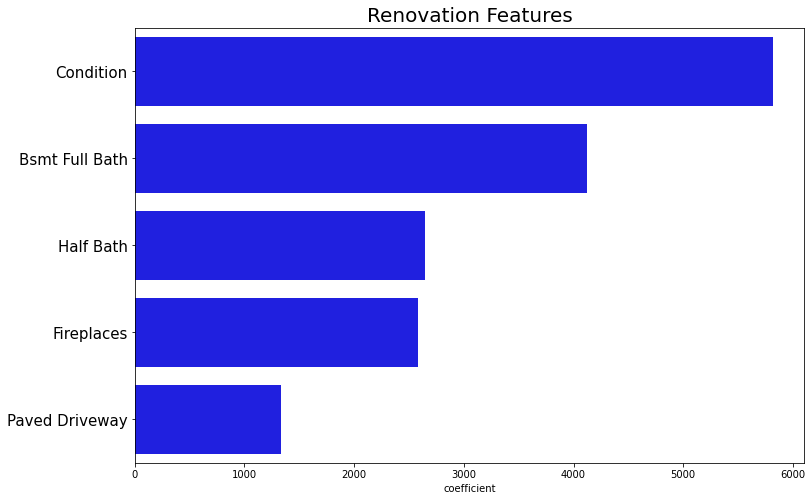

In [25]:
f,ax = plt.subplots()

sns.barplot(y = renovation_df.index, x = renovation_df['coefficient'], color='blue', orient='h', ax=ax)
plt.title('Renovation Features', size=20)
ax.yaxis.set_tick_params(labelsize=15);

f.savefig("../plots/renovation-features.png", bbox_inches='tight', dpi=600)

**Interpretation:** These features are all less important to sale price than the 'set' features examined above this plot. The number of bathrooms and fireplaces stand out as important additions to homes in Ames.

# Train model on unscaled data
* For interpretability.
* Extract specific dollar increase/decrease in home sale price as feature value changes.

In [26]:
# Set features and target
X = train._get_numeric_data().drop(columns='SalePrice')
y = train['SalePrice']

# Save column names
features = list(X.columns)

In [27]:
# Create model
model = LinearRegression()

# Fit the model on training data
model.fit(X, y)

LinearRegression()

### Investigate Coefficients

In [28]:
coef = build_coef_df(features, model)

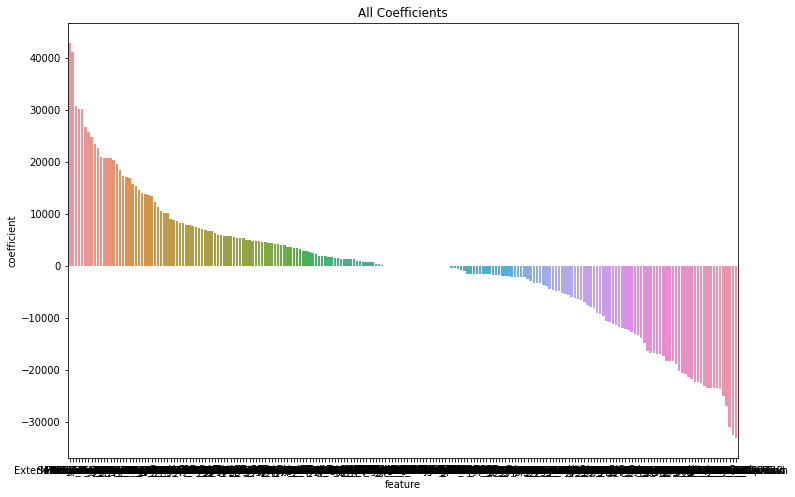

In [29]:
sns.barplot(x=coef.index, y='coefficient', data=coef)
plt.title('All Coefficients');

**Interpretation:** Feature impacts are more evenly spread out compared to the model trained on scaled data. Let's take a closer look at the most impactful features.

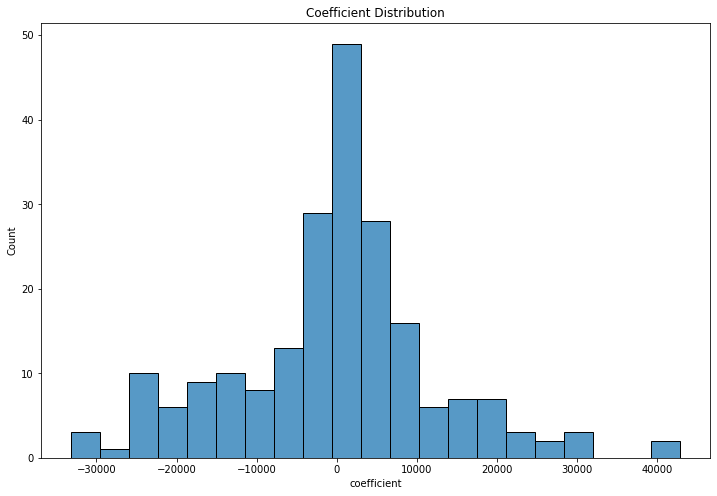

In [30]:
sns.histplot(coef['coefficient'])
plt.title('Coefficient Distribution');

**Interpretation:** Distribution of coefficients is approximately Gaussian.

## Features with large contribution to target
**Numeric Features**

In [31]:
numeric_cols = get_numeric_features(coef)
num_df = coef.loc[numeric_cols, :]
num_df.head()

,coefficient
feature,
Bsmt Full Bath,7900.71
Full Bath,5445.42
Half Bath,5275.94
Overall Cond,5264.08
Fireplaces,4055.4


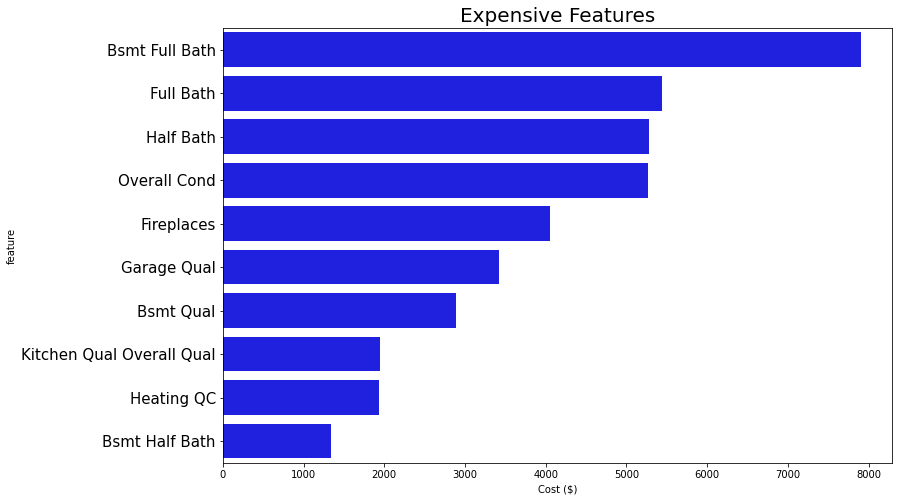

In [32]:
df = num_df.head(10)

f,ax = plt.subplots()

sns.barplot(y = df.index, x = df['coefficient'], color='blue', orient='h', ax=ax)
plt.title('Expensive Features', size=20)
plt.xlabel('Cost ($)')
ax.yaxis.set_tick_params(labelsize=15);

**Interpretation:** Unit for unit, adding bathrooms has the greatest effect on price increase of any non-binary feature. Each full bathroom added to the basement adds nearly \\$8,000 in sale price value, according to the model.

In [33]:
df.head(3)

,coefficient
feature,
Bsmt Full Bath,7900.71
Full Bath,5445.42
Half Bath,5275.94


**Interpretation:** Price increase in USD per bathroom added.

**Binary Features**

In [34]:
binary_cols = get_binary_features(coef)
binary_df = coef.loc[binary_cols, :]

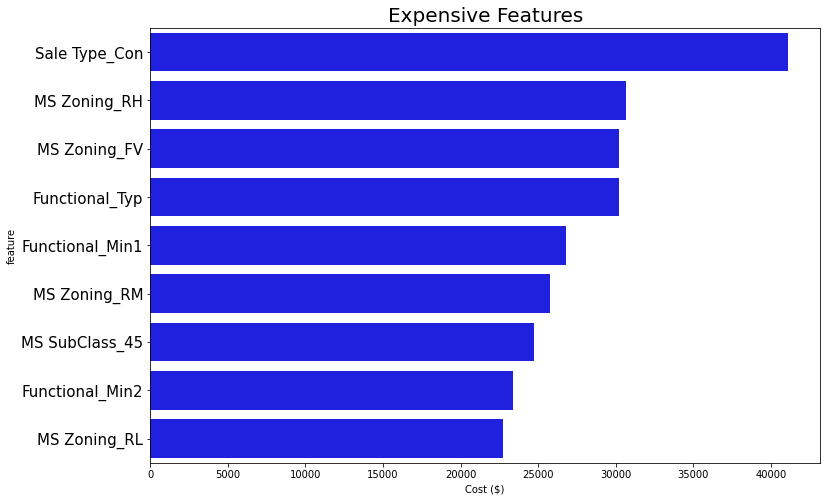

In [35]:
df = binary_df.iloc[1:10]

f,ax = plt.subplots()

sns.barplot(y = df.index, x = df['coefficient'], color='blue', orient='h', ax=ax)
plt.title('Expensive Features', size=20)
plt.xlabel('Cost ($)')
ax.yaxis.set_tick_params(labelsize=15);

**Interpretation:** Some of these features do not make sense to me intuitively. Why is high density residential second on this list as adding the most cost to sale price, when the scaled model coefficients showed the opposite? Why is minor deductions 1 and 2 up in the top 10 for adding the most value? If I had more time I would refine my model through feature selections and see if this phenomenon persists.